In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display

In [142]:
csv = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

csv.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


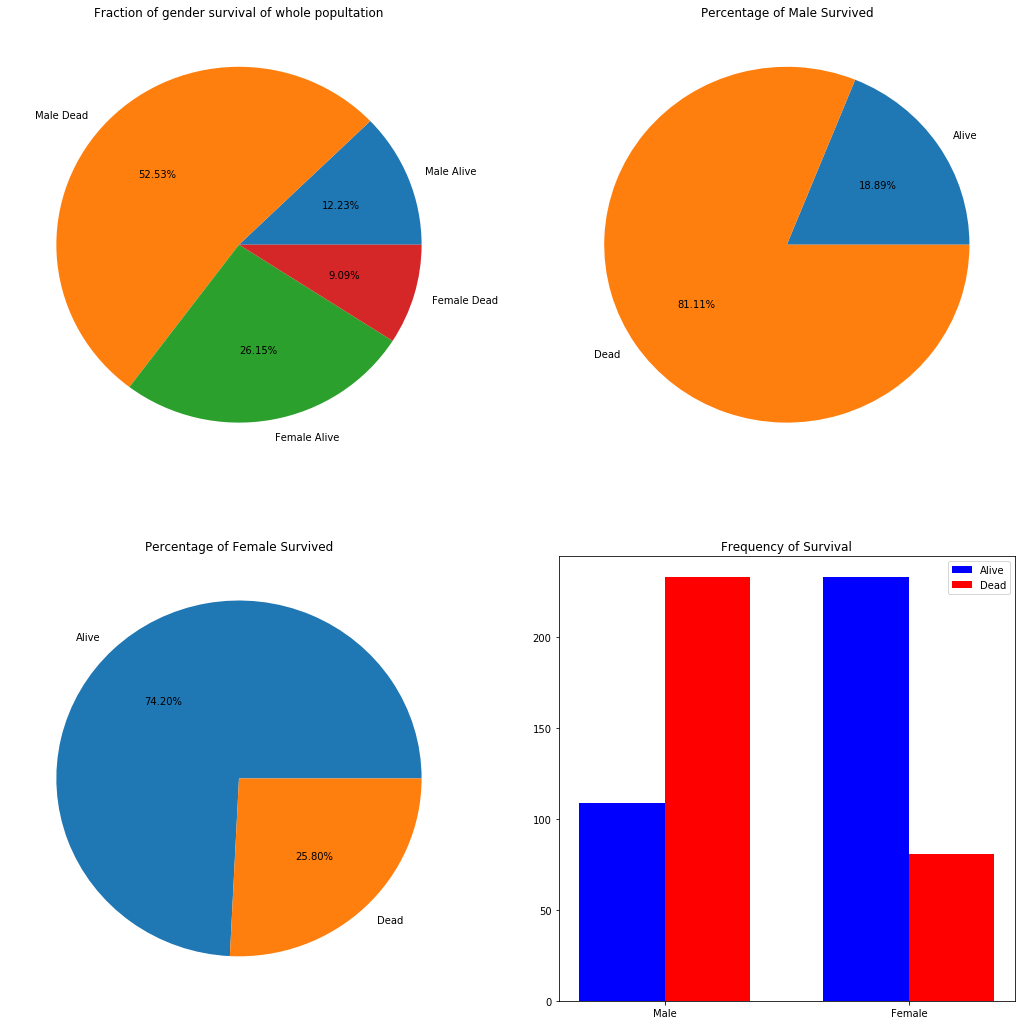

In [3]:
# Lets start with processing gender.
# Woman and kids should have higher chance to survive
# Is there really such correlation?

gender = csv[["Sex","Survived"]]

total = len(gender)
male = gender.query("Sex == 'male'")
female = gender.query("Sex == 'female'")

totalMale = len(male)
totalFemale = len(female)
maleAlive = len( male.query("Survived == 1") )
femaleAlive = len ( female.query("Survived == 1") )
maleDead = totalMale - maleAlive
femaleDead = totalFemale - femaleAlive

fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(18,18))

# Total Population
labels = ["Male Alive", "Male Dead", "Female Alive", "Female Dead"]
fracs = [maleAlive,maleDead,femaleAlive,femaleDead]
ax[0,0].pie(fracs,labels=labels,autopct='%.2f%%')
ax[0,0].set_title("Fraction of gender survival of whole popultation")

# Male population Ratio
ax[0,1].set_title("Percentage of Male Survived")
labels = ["Alive", "Dead"]
fracs = [maleAlive,maleDead]
ax[0,1].pie(fracs,labels=labels,autopct='%.2f%%')

# Female population Ratio
ax[1,0].set_title("Percentage of Female Survived")
labels = ["Alive", "Dead"]
fracs = [femaleAlive,femaleDead]
ax[1,0].pie(fracs,labels=labels,autopct='%.2f%%')

ax[1,1].set_title("Frequency of Survival")
labels = ["Male", "Female"]
ind = np.arange(2)
aliveBar = ax[1,1].bar(ind, [maleAlive, femaleAlive], 0.35, color='b')
deadBar = ax[1,1].bar(ind+0.35, [femaleAlive,femaleDead], 0.35, color='r')

ax[1,1].set_xticks(ind + 0.35 / 2)
ax[1,1].set_xticklabels(labels)
ax[1,1].legend((aliveBar[0], deadBar[0]), ["Alive", "Dead"])

temp = plt.plot()

# Correlation with Gender

Seems like, more females than males have survived the incident. Gender seems to be a special feature. I wonder what will happen if I make my predictions based on gender only?

# Prediction #001 - Based on Gender Only

In [27]:
# Probablity of men surviving?

pMale = maleAlive / totalMale
pFemale = femaleAlive / totalFemale

def surviveOrNot (gender):
    """Returns whether 'gender' will survive or not, based on random probability"""
    prob = pMale if gender == 'male' else pFemale
    x = np.random.rand()
    return 1 if x <= prob else 0

print ( "Male Survival Prob: {} and Female Survival Prob: {}".format(pMale,pFemale))

# So for each male/female in test file, we simply generate random number and decide if she survives or not

testGender = test.loc[:,('Sex','PassengerId')]
testGender.loc[:,'Survived'] = [ surviveOrNot(x) for x in testGender['Sex'] ]
del testGender['Sex']
testGender.to_csv('001_gender_only.csv', index=False)

Male Survival Prob: 0.18890814558058924 and Female Survival Prob: 0.7420382165605095


## Result - 0.59809

So I got more than half correct. Not bad, considering this was very naive approach. Oh well, at least I drew some nice graphs :D

# What's next?

Next, I will try using linear regression. I will probably need to clean up my data and convert them to numeric values. Before cleaning, I will probably need to convert string values to numeric where possible.

# Cleaning Data

In [69]:
def checkMissingValues(column):
    return csv[column].isnull().values.any() or test[column].isnull().values.any()

print ( "Let's see if we have any missing values" )
display(csv.head())

for x in csv.columns:
    if ( x == 'Survived' ):
        continue
    if ( checkMissingValues(x) ):
        print ( "Some missing values in", x )

Let's see if we have any missing values


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Some missing values in Age
Some missing values in Fare
Some missing values in Cabin
Some missing values in Embarked


Lets ignore Cabin for now.

## Cleaning Policy

I think I am going to replace all missing values with median of that column. 

First lets, convert Embarked to numeric value

In [155]:
cleanColumn = 'Embarked'
display ( csv['Embarked'].unique() )

embarkMap = { 'S': 0, 'C' : 1, 'Q' : 2 }
def convertEmbark(x):
    if pd.isnull(x):
        return np.nan
    if type(x) is str:
        return embarkMap[x]
    return x

csv[cleanColumn] = csv[cleanColumn].map( convertEmbark )
test[cleanColumn] = test[cleanColumn].map( convertEmbark )

csv[cleanColumn] = csv[cleanColumn].fillna( csv[cleanColumn].median() )
test[cleanColumn] = test[cleanColumn].fillna( test[cleanColumn].median() )


array([ 0.,  1.,  2.])